## WY2017 (wet year) analysis

- SWE and saturation time series for the full WY
- Evaporative fraction for the full WY
- Summer VWC
- Change in summer subsurface storage across root zone layers, baseline and warming simulations
- Summer transpiration, effect of warming
- Summer recharge (infil - transpiration), effect of warming
- Landcover info

In [29]:
import os
import sys
from parflow.tools import Run
from parflow.tools.fs import mkdir, cp, get_absolute_path, exists
from parflow.tools.settings import set_working_directory
from parflow.tools.io import read_pfb,write_pfb, read_clm
import parflow.tools.hydrology as hydro
import parflow as pf
from parflow import Run

from glob import glob
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import calendar
from matplotlib import colors 
import matplotlib.dates as mdates

In [2]:
"""
Creating the run object from the pdifb and getting grid size and shape. 
Then creating data accessor object ("data = ...")
"""
runname = 'East_taylor_newbounds_1.wy2017'
run_dir=''
run_dir = get_absolute_path(runname)

path_run = f'/hydrodata/temp/EastTaylor_ashley/{runname}/'

run = Run.from_definition(f'{path_run}{runname}.pfidb')
run.Solver.CLM.MetFilePath = '~/EastTaylor_inputs/newbounds_CW3E_WY2017' # forcing

data = run.data_accessor # creating data accessor object 
dx = data.dx
dy = data.dy
dz = data.dz

nz,ny,nx = data.shape

porosity= data.computed_porosity
specific_storage = data.specific_storage
mask = data.mask
mask[mask>0]=1 # PF has big # instead of 1 so change to 1 bc more manageable
surf_mask = mask[-1,:,:] # last element of first axis (always be surface no matter what)


# Mannings not always printed as outputm so it's a special case
if run.Mannings.Type == 'PFBFile':
    mannings = np.squeeze(read_pfb(f'{path_run}{run.Mannings.FileName}'))
elif run.Mannings.Type == 'Constant':
    mannings = run.Mannings.Geom.domain.Value
slopex = np.squeeze(data.slope_x)
slopey = np.squeeze(data.slope_y)

# for converting from LH to ET
rho_w = 1000 # kg/m3
hvap   = 2.5104e06

print(dx, dy)

nanmask=mask.copy()
nanmask[nanmask == 0] = 'NaN'
nanmask[nanmask > 0] = 1

print(data.shape)
print(ny)
print(dz)

Solver: Field BinaryOutDir is not part of the expected schema <class 'parflow.tools.database.generated.Solver'>
  - nt
  - sw_ini
  - hkdepth
  - wtfact
  - trsmx0
  - smpmax
  - pondmx


/home/SHARED/virtual-environments/parflow-shared/conda/lib/python3.11/site-packages/parflow/tools/io.py:1300: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(file_name, delim_whitespace=True, skiprows=2, header=None)


1000 1000
(10, 48, 67)
48
[2.0e+02 1.0e+02 5.0e+01 2.5e+01 1.0e+01 5.0e+00 1.0e+00 6.0e-01 3.0e-01
 1.0e-01]


## SWE & saturation (full WY)

In [6]:
year = 2017
if calendar.isleap(year) == False:

    num_tsteps = 8760+1
else: 
    num_tsteps = 8784+1

In [22]:
# reading in swe by point

swe_bypixel = np.zeros((num_tsteps, ny, nx))
swe = np.zeros(num_tsteps)

for t in range(0,num_tsteps):
    data.time = t
            
    if t > 0: 
        data.forcing_time = t-1
        swe[t]  = np.sum(data.clm_output('swe_out')[surf_mask==1])#*(1/1000)*(dx)*(dy)
        swe_bypixel[t, :, :]  = data.clm_output('swe_out')

np.save("swe_bypixel", swe_bypixel)
np.save("swe_wy2017", swe)
swe_bypixel.shape


NameError: name 'num_tsteps' is not defined

In [27]:
swe = np.load("swe_wy2017.npy")
swe = swe*(1/1000)*dx*dy

swe_bypixel = np.load("swe_bypixel.npy")
swe_bypixel = swe_bypixel*(1/1000)*dx*dy
print(swe.shape)
print(swe_bypixel.shape)

(8761,)
(8761, 48, 67)


In [24]:
swe_warm = np.load('swe_wy2017_warm.npy')
swe_warm = swe_warm*(1/1000)*dx*dy

swe_warm_bypixel = np.load('swe_bypixel_warm.npy')
swe_warm_bypixel = swe_warm_bypixel*(1/1000)*dx*dy

Text(0, 0.5, '$m^3$')

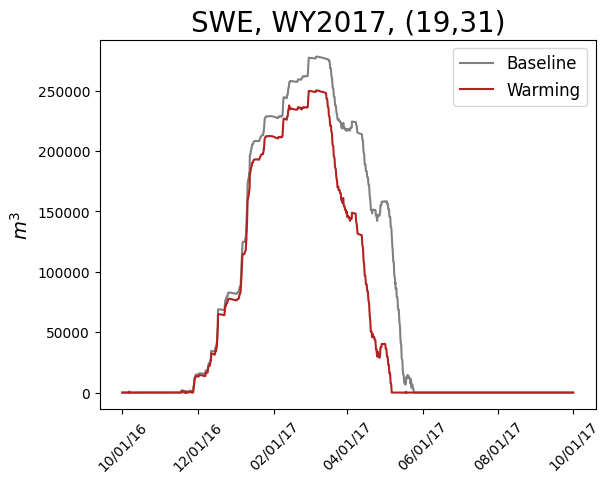

In [15]:
start_date = '2016-10-01'
end_date = '2017-10-01'  

dates = pd.date_range(start=start_date, end=end_date, freq='h')

plt.plot(dates, swe_bypixel[:,19,31], label='Baseline', color = 'gray')
plt.plot(dates, swe_warm_bypixel[:,19,31], label='Warming', color= 'firebrick')

plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=2))   # First of each month
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m/%d/%y')) 

plt.xticks(rotation=45)

plt.legend(fontsize = 12)
plt.title('SWE, WY2017, (19,31)', fontsize = 20)
plt.ylabel('$m^3$', fontsize = 14)

In [16]:
for i in range (len(swe)):
    if i > 3000 and swe[i] == 0:
        melt_hr_og = i
        print('hr no swe, original = ', melt_hr_og)
        break

hr no swe, original =  6663


In [17]:
for i in range (len(swe)):
    if i > 3000 and swe_warm[i] == 0:
        melt_hr_warm = i
        print('hr no swe, warm = ', melt_hr_warm)
        break

hr no swe, warm =  6476


In [18]:
print((melt_hr_og - melt_hr_warm)/24)

7.791666666666667


In [7]:
sat_10cm = np.zeros((num_tsteps, ny, nx)) 
sat_40cm = np.zeros((num_tsteps, ny, nx)) 
sat_1m = np.zeros((num_tsteps, ny, nx))

for t in range(0, num_tsteps):
    data.time = t

    sat_10cm[t] = data.saturation[9,:,:]
    sat_40cm[t] = data.saturation[8,:,:]
    sat_1m[t] = data.saturation[7,:,:]

np.save("sat_10cm", sat_10cm)
np.save("sat_40cm", sat_40cm)
np.save("sat_1m", sat_1m)

In [25]:
sat_10cm = np.load("sat_10cm.npy") 
sat_40cm = np.load("sat_40cm.npy")
sat_1m = np.load("sat_1m.npy")


sat_10cm_warm = np.load('sat_10cm_warm.npy')

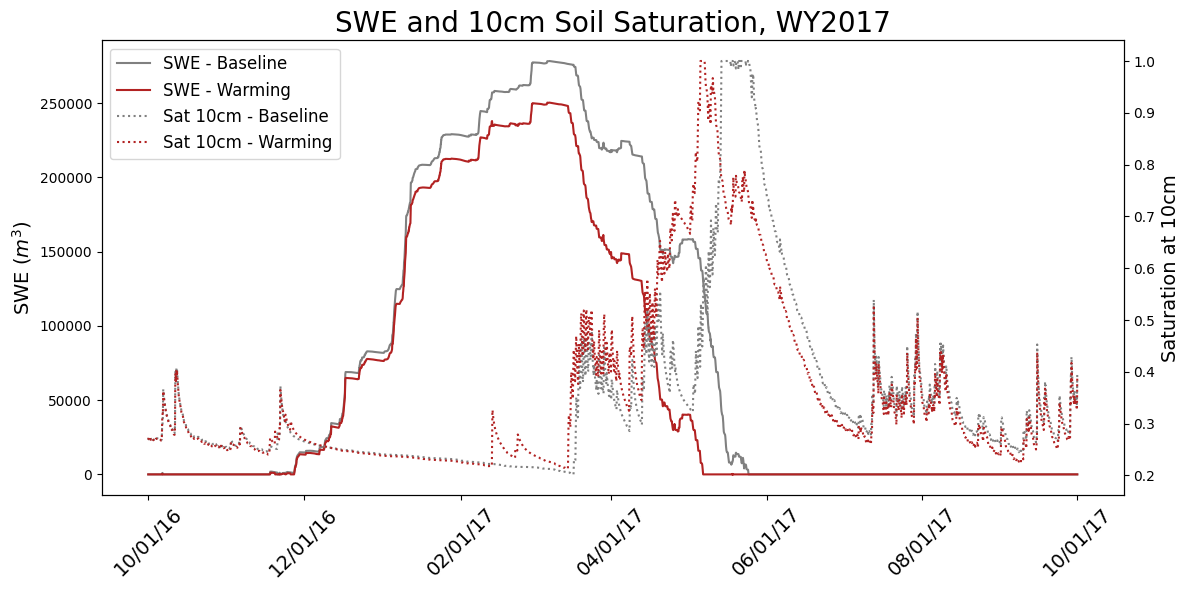

In [28]:
start_date = '2016-10-01'
end_date = '2017-10-01'
dates = pd.date_range(start=start_date, end=end_date, freq='h')

fig, ax1 = plt.subplots(figsize=(12, 6))

ax1.plot(dates, swe_bypixel[:,19,31], label='SWE - Baseline', color='gray')
ax1.plot(dates, swe_warm_bypixel[:,19,31], label='SWE - Warming', color='firebrick')
ax1.set_ylabel('SWE ($m^3$)', fontsize=14, color='black')
ax1.tick_params(axis='y', labelcolor='black')

ax1.xaxis.set_major_locator(mdates.MonthLocator(interval=2))
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%m/%d/%y'))
plt.xticks(rotation=45, fontsize = 14)

ax2 = ax1.twinx()
ax2.plot(dates, sat_10cm[:,19,31], label='Sat 10cm - Baseline', color='gray', linestyle=':')
ax2.plot(dates, sat_10cm_warm[:,19,31], label='Sat 10cm - Warming', color='firebrick', linestyle=':')
ax2.set_ylabel('Saturation at 10cm', fontsize=14, color='black')
ax2.tick_params(axis='y', labelcolor='black')

lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax1.legend(lines_1 + lines_2, labels_1 + labels_2, fontsize=12, loc='upper left')

plt.title('SWE and 10cm Soil Saturation, WY2017', fontsize=20)
plt.tight_layout()
plt.show()


## Evaporative Fraction (ET/P) over the whole water year

In [4]:
# calculating total precip and et at each cell
precip_tot = np.zeros((ny,nx))
et_tot = np.zeros((ny,nx))

num_tsteps = 8760+1

 # 2d array for precip at particular timestep for each cell
precip_timestep = np.zeros((ny,nx))
et_timestep = np.zeros((ny,nx))

for t in range(0,num_tsteps):
    data.time = t

    
    if t > 0: 
        data.forcing_time = t-1
        # 2d array for that particular timestep
        precip_timestep= data.clm_forcing_apcp*3600

        # array of the cumulative precip at each grid cell
        precip_tot += precip_timestep


        et_timestep = data.clm_output('eflx_lh_tot') * (1 / rho_w) * (1 / hvap)*3600*1000  # converting from m/s to mm/hr 

        et_tot += et_timestep

np.save("precip_tot", precip_tot)
np.save("domain_et_tot", et_tot)

In [10]:
precip_tot = np.load("precip_tot.npy")
yr_et_tot = np.load("domain_et_tot.npy")

In [11]:
precip_tot = precip_tot*nanmask
yr_et_tot = yr_et_tot*nanmask

In [12]:
precip_tot_domain = np.nansum(precip_tot)
precip_tot_domain

yr_et_tot_domain = np.nansum(yr_et_tot)
yr_et_tot_domain

np.float64(8174190.0941501595)

In [13]:
evap_frac = yr_et_tot_domain / precip_tot_domain
evap_frac

np.float64(0.596010325160917)

# Summer VWC

In [6]:
# 273 days between 10/1/2002 and 7/1/2003
# 62 days until 9/1/2003 from the start of july

summer_tstart = 273*24 # hour in the WY that july starts
summer_tend = (273+62)*24 # hour marking the start of september
summer_numtsteps = summer_tend - summer_tstart + 1
print((summer_numtsteps-1)/24)

62.0


In [16]:
# arrays to hold soil moisture values at each time for each grid cell at varying depths
summer_sm_10cm = np.zeros((summer_numtsteps, ny, nx)) 
summer_sm_40cm = np.zeros((summer_numtsteps, ny, nx)) 
summer_sm_1m = np.zeros((summer_numtsteps, ny, nx)) 
summer_sm_2m = np.zeros((summer_numtsteps, ny, nx)) 
summer_sm_7m = np.zeros((summer_numtsteps, ny, nx)) 

# arrays to hold cumulative transpiration at each grid cell
summer_tran_sum = np.zeros((ny, nx))

# cumulative ground infiltration at each grid cell over the summer
summer_infl_sum = np.zeros((ny, nx))

# looping over july-september
for t in range(0, summer_numtsteps):
    data.time = t + summer_tstart # first index will be first hour of july

    # soil moisture (VWC) at each time step for each grid cell
    summer_sm_10cm[t] = data.saturation[9,:,:]*porosity[9,:,:] 
    summer_sm_40cm[t] = data.saturation[8,:,:]*porosity[8,:,:] 
    summer_sm_1m[t] = data.saturation[7,:,:]*porosity[7,:,:] 
    summer_sm_2m[t] = data.saturation[6,:,:]*porosity[6,:,:] 
    summer_sm_7m[t] = data.saturation[5,:,:]*porosity[5,:,:] 

    
    # 2d arrays for transpiration at that particular timestep
    tran_timestep = data.clm_output('qflx_tran_veg') * 3600  # converting from mm/s to mm/hr

    #total t for each grid cell
    summer_tran_sum += tran_timestep


    # 2d infiltration array for that particular timestep
    infl_timestep = data.clm_output('qflx_infl')*3600 # converting from mm/s to mm/hr

    # total infiltration for each grid cell
    summer_infl_sum += infl_timestep



np.save("summer_sm_10cm", summer_sm_10cm)
np.save("summer_sm_40cm", summer_sm_40cm)
np.save("summer_sm_1m", summer_sm_1m)
np.save("summer_sm_2m", summer_sm_2m)
np.save("summer_sm_7m", summer_sm_7m)

np.save("summer_tran_sum", summer_tran_sum)

np.save("summer_infl_sum", summer_infl_sum)

In [3]:
summer_sm_10cm = np.load("summer_sm_10cm.npy")
summer_sm_40cm = np.load("summer_sm_40cm.npy")
summer_sm_1m = np.load("summer_sm_1m.npy")
summer_sm_2m = np.load("summer_sm_2m.npy")
summer_sm_7m = np.load("summer_sm_7m.npy")

summer_tran_sum = np.load("summer_tran_sum.npy")

summer_infl_sum = np.load("summer_infl_sum.npy")

summer_sm_10cm.shape


summer_sm_10cm_warm = np.load('summer_sm_10cm_warm.npy')
summer_sm_40cm_warm = np.load('summer_sm_40cm_warm.npy')
summer_sm_1m_warm = np.load('summer_sm_1m_warm.npy')
summer_sm_2m_warm = np.load('summer_sm_2m_warm.npy')
summer_sm_7m_warm = np.load('summer_sm_7m_warm.npy')


0.22745638416668262
0.40942509773926844
0.09518136240594986


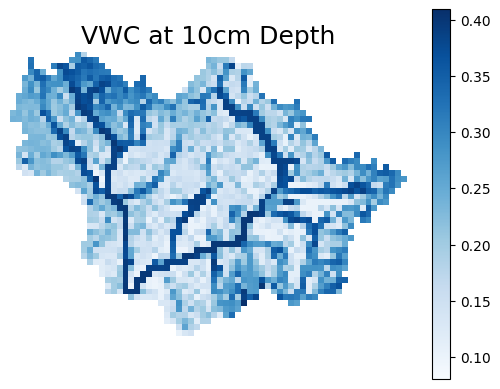

In [41]:
summer_sm_10cm_avg = summer_sm_10cm.mean(axis = 0)
summer_sm_10cm_avg.shape

plt.imshow(np.ma.masked_array(summer_sm_10cm_avg, surf_mask==0),origin='lower', cmap = 'Blues', vmin = 0.08022454006808227)
cbar = plt.colorbar()
plt.axis('off')
plt.title('VWC at 10cm Depth', fontsize = 18)
#cbar.set_label('VWC', fontsize = 14)  # Set the label for the colorbar
basin_avg_sm = np.nanmean(summer_sm_10cm_avg*nanmask)
print(basin_avg_sm)
print(np.nanmax(summer_sm_10cm_avg*nanmask))
print(np.nanmin(summer_sm_10cm_avg*nanmask))

In [5]:
# converting to just saturation not vwc
summer_s_10cm = summer_sm_10cm/porosity[9,:,:]
summer_s_40cm = summer_sm_40cm/porosity[8,:,:]
summer_s_1m = summer_sm_1m/porosity[7,:,:]
summer_s_2m = summer_sm_2m/porosity[6,:,:]
summer_s_7m = summer_sm_7m/porosity[5,:,:]

summer_s_10cm_warm = summer_sm_10cm_warm/porosity[9,:,:]
summer_s_40cm_warm = summer_sm_40cm_warm/porosity[8,:,:]
summer_s_1m_warm = summer_sm_1m_warm/porosity[7,:,:]
summer_s_2m_warm = summer_sm_2m_warm/porosity[6,:,:]
summer_s_7m_warm = summer_sm_7m_warm/porosity[5,:,:]

# Change in subsurface storage over the root zone

## Calculating daily average changes using subsurface storage output

In [21]:
## using subsurface storage to look at changes in soil moisture across layers

press_files = glob(f'{run_dir}*out.press*.pfb')
#print(lw_press_files)
#read in all pressure files into a 3D NParray
pressure_arrays = pf.read_pfb_sequence(press_files) * nanmask

#list all saturation files from outputs
satur_files = glob(f'{run_dir}*out.satur*.pfb')
#read in all sat files into a 3D NParray
saturation_arrays = pf.read_pfb_sequence(satur_files) * nanmask


subsurf_storage_bylayer = np.zeros((summer_numtsteps, nz, ny, nx))

for i in range(summer_numtsteps):
    data.time = i + summer_tstart # first index will be first hour of july
    subsurf_storage_bylayer[i, :,:,:] = hydro.calculate_subsurface_storage(porosity, pressure_arrays[i + summer_tstart,:,:,:], saturation_arrays[i + summer_tstart,:,:,:], data.specific_storage, dx, dy, dz, mask = nanmask)

np.save('subsurf_storage_bylayer', subsurf_storage_bylayer)


In [4]:
subsurf_storage_bylayer =  np.load('subsurf_storage_bylayer.npy')

subsurf_storage_bylayer_warm = np.load('subsurf_storage_bylayer_warm.npy')

In [7]:
# baseline
summer_numdays = int((summer_numtsteps - 1)/24) # each timestep is an hr

subsurf_change_10cm = np.zeros((summer_numdays, ny,nx))
subsurf_change_40cm = np.zeros((summer_numdays, ny,nx))
subsurf_change_1m = np.zeros((summer_numdays, ny,nx))
subsurf_change_2m = np.zeros((summer_numdays, ny,nx))
subsurf_change_7m = np.zeros((summer_numdays, ny,nx))

for day in range(0, summer_numdays-1):
    hr = day*24
    subsurf_change_10cm[day,:,:] = (subsurf_storage_bylayer[hr+24, 9, :,:] - subsurf_storage_bylayer[hr,9,:,:])
    subsurf_change_40cm[day,:,:] = (subsurf_storage_bylayer[hr+24, 8, :,:] - subsurf_storage_bylayer[hr,8,:,:])
    subsurf_change_1m[day,:,:] = (subsurf_storage_bylayer[hr+24, 7, :,:] - subsurf_storage_bylayer[hr,7,:,:])
    subsurf_change_2m[day,:,:] = (subsurf_storage_bylayer[hr+24, 6, :,:] - subsurf_storage_bylayer[hr,6,:,:])
    subsurf_change_7m[day,:,:] = (subsurf_storage_bylayer[hr+24, 5, :,:] - subsurf_storage_bylayer[hr,5,:,:])

# daily average
subsurf_change_10cm_avg = np.mean(subsurf_change_10cm, axis = 0)
subsurf_change_40cm_avg = np.mean(subsurf_change_40cm, axis = 0)
subsurf_change_1m_avg = np.mean(subsurf_change_1m, axis = 0)
subsurf_change_2m_avg = np.mean(subsurf_change_2m, axis = 0)
subsurf_change_7m_avg = np.mean(subsurf_change_7m, axis = 0)

# domain average
subsurf_change_10cm_avg_domain = np.nanmean(subsurf_change_10cm_avg*nanmask)
subsurf_change_40cm_avg_domain = np.nanmean(subsurf_change_40cm_avg*nanmask)
subsurf_change_1m_avg_domain = np.nanmean(subsurf_change_1m_avg*nanmask)
subsurf_change_2m_avg_domain = np.nanmean(subsurf_change_2m_avg*nanmask)
subsurf_change_7m_avg_domain = np.nanmean(subsurf_change_7m_avg*nanmask)


print(subsurf_change_10cm_avg_domain)
print(subsurf_change_40cm_avg_domain)
print(subsurf_change_1m_avg_domain)
print(subsurf_change_2m_avg_domain)
print(subsurf_change_7m_avg_domain)


-33.31088754664627
-127.61407731086564
-150.93170727895256
-31.502313465214936
-2.198797899855126


In [8]:
#warming
summer_numdays = int((summer_numtsteps - 1)/24) # each timestep is an hr

subsurf_change_10cm_warm = np.zeros((summer_numdays, ny,nx))
subsurf_change_40cm_warm = np.zeros((summer_numdays, ny,nx))
subsurf_change_1m_warm = np.zeros((summer_numdays, ny,nx))
subsurf_change_2m_warm = np.zeros((summer_numdays, ny,nx))
subsurf_change_7m_warm = np.zeros((summer_numdays, ny,nx))

for day in range(0, summer_numdays-1):
    hr = day*24
    subsurf_change_10cm_warm[day,:,:] = (subsurf_storage_bylayer_warm[hr+24, 9, :,:] - subsurf_storage_bylayer_warm[hr,9,:,:])
    subsurf_change_40cm_warm[day,:,:] = (subsurf_storage_bylayer_warm[hr+24, 8, :,:] - subsurf_storage_bylayer_warm[hr,8,:,:])
    subsurf_change_1m_warm[day,:,:] = (subsurf_storage_bylayer_warm[hr+24, 7, :,:] - subsurf_storage_bylayer_warm[hr,7,:,:])
    subsurf_change_2m_warm[day,:,:] = (subsurf_storage_bylayer_warm[hr+24, 6, :,:] - subsurf_storage_bylayer_warm[hr,6,:,:])
    subsurf_change_7m_warm[day,:,:] = (subsurf_storage_bylayer_warm[hr+24, 5, :,:] - subsurf_storage_bylayer_warm[hr,5,:,:])

# daily average
subsurf_change_10cm_avg_warm = np.mean(subsurf_change_10cm_warm, axis = 0)
subsurf_change_40cm_avg_warm = np.mean(subsurf_change_40cm_warm, axis = 0)
subsurf_change_1m_avg_warm = np.mean(subsurf_change_1m_warm, axis = 0)
subsurf_change_2m_avg_warm = np.mean(subsurf_change_2m_warm, axis = 0)
subsurf_change_7m_avg_warm = np.mean(subsurf_change_7m_warm, axis = 0)

# domain average
subsurf_change_10cm_avg_domain_warm = np.nanmean(subsurf_change_10cm_avg_warm*nanmask)
subsurf_change_40cm_avg_domain_warm = np.nanmean(subsurf_change_40cm_avg_warm*nanmask)
subsurf_change_1m_avg_domain_warm = np.nanmean(subsurf_change_1m_avg_warm*nanmask)
subsurf_change_2m_avg_domain_warm = np.nanmean(subsurf_change_2m_avg_warm*nanmask)
subsurf_change_7m_avg_domain_warm = np.nanmean(subsurf_change_7m_avg_warm*nanmask)


print(subsurf_change_10cm_avg_domain_warm)
print(subsurf_change_40cm_avg_domain_warm)
print(subsurf_change_1m_avg_domain_warm)
print(subsurf_change_2m_avg_domain_warm)
print(subsurf_change_7m_avg_domain_warm)

-19.03160876710104
-98.30412056177363
-196.71205557270437
-37.33857858783927
-7.21444800461637


In [9]:
# WY2018 values (from other notebook)
subsurf_change_10cm_avg_domain_2018 = -49.306556570798605
subsurf_change_40cm_avg_domain_2018 = -222.79709466466144
subsurf_change_1m_avg_domain_2018 = -368.9776264019626
subsurf_change_2m_avg_domain_2018 = -77.45966569783977
subsurf_change_7m_avg_domain_2018 = -10.974629199206525

subsurf_change_10cm_avg_domain_2018_warm = -39.46139679092305
subsurf_change_40cm_avg_domain_2018_warm = -190.76162167585892
subsurf_change_1m_avg_domain_2018_warm = -417.4586177550696
subsurf_change_2m_avg_domain_2018_warm = -91.74802906189828
subsurf_change_7m_avg_domain_2018_warm = -16.068375258160447


In [10]:
# converting from m3 to mm - WY2017
# these values represent the per-pixel domain average, so just have to divide by pixel size (1km2 = 1e12 mm2)
# currently in m3 = 1e9 mm3

# baseline
# convert to mm3
subsurf_change_10cm_avg_domain = subsurf_change_10cm_avg_domain * 10**9 
subsurf_change_40cm_avg_domain = subsurf_change_40cm_avg_domain * 10**9
subsurf_change_1m_avg_domain = subsurf_change_1m_avg_domain * 10**9
subsurf_change_2m_avg_domain = subsurf_change_2m_avg_domain * 10**9
subsurf_change_7m_avg_domain = subsurf_change_7m_avg_domain * 10**9

# convert to mm
subsurf_change_10cm_avg_domain = subsurf_change_10cm_avg_domain / 10**12
subsurf_change_40cm_avg_domain = subsurf_change_40cm_avg_domain / 10**12
subsurf_change_1m_avg_domain = subsurf_change_1m_avg_domain / 10**12
subsurf_change_2m_avg_domain = subsurf_change_2m_avg_domain / 10**12
subsurf_change_7m_avg_domain = subsurf_change_7m_avg_domain / 10**12


# warmed
subsurf_change_10cm_avg_domain_warm = subsurf_change_10cm_avg_domain_warm * 10**9 
subsurf_change_40cm_avg_domain_warm = subsurf_change_40cm_avg_domain_warm * 10**9
subsurf_change_1m_avg_domain_warm = subsurf_change_1m_avg_domain_warm * 10**9
subsurf_change_2m_avg_domain_warm = subsurf_change_2m_avg_domain_warm * 10**9
subsurf_change_7m_avg_domain_warm = subsurf_change_7m_avg_domain_warm * 10**9

subsurf_change_10cm_avg_domain_warm = subsurf_change_10cm_avg_domain_warm / 10**12
subsurf_change_40cm_avg_domain_warm = subsurf_change_40cm_avg_domain_warm / 10**12
subsurf_change_1m_avg_domain_warm = subsurf_change_1m_avg_domain_warm / 10**12
subsurf_change_2m_avg_domain_warm = subsurf_change_2m_avg_domain_warm / 10**12
subsurf_change_7m_avg_domain_warm = subsurf_change_7m_avg_domain_warm / 10**12

In [11]:
# converting from m3 to mm - WY2018
# these values represent the per-pixel domain average, so just have to divide by pixel size (1km2 = 1e12 mm2)
# currently in m3 = 1e9 mm3

# baseline
# convert to mm3
subsurf_change_10cm_avg_domain_2018  = subsurf_change_10cm_avg_domain_2018  * 10**9 
subsurf_change_40cm_avg_domain_2018  = subsurf_change_40cm_avg_domain_2018  * 10**9
subsurf_change_1m_avg_domain_2018  = subsurf_change_1m_avg_domain_2018  * 10**9
subsurf_change_2m_avg_domain_2018  = subsurf_change_2m_avg_domain_2018  * 10**9
subsurf_change_7m_avg_domain_2018  = subsurf_change_7m_avg_domain_2018  * 10**9

# convert to mm
subsurf_change_10cm_avg_domain_2018  = subsurf_change_10cm_avg_domain_2018  / 10**12
subsurf_change_40cm_avg_domain_2018  = subsurf_change_40cm_avg_domain_2018  / 10**12
subsurf_change_1m_avg_domain_2018  = subsurf_change_1m_avg_domain_2018  / 10**12
subsurf_change_2m_avg_domain_2018  = subsurf_change_2m_avg_domain_2018  / 10**12
subsurf_change_7m_avg_domain_2018  = subsurf_change_7m_avg_domain_2018  / 10**12


# warmed
subsurf_change_10cm_avg_domain_2018_warm = subsurf_change_10cm_avg_domain_2018_warm * 10**9 
subsurf_change_40cm_avg_domain_2018_warm = subsurf_change_40cm_avg_domain_2018_warm * 10**9
subsurf_change_1m_avg_domain_2018_warm = subsurf_change_1m_avg_domain_2018_warm * 10**9
subsurf_change_2m_avg_domain_2018_warm = subsurf_change_2m_avg_domain_2018_warm * 10**9
subsurf_change_7m_avg_domain_2018_warm = subsurf_change_7m_avg_domain_2018_warm * 10**9

subsurf_change_10cm_avg_domain_2018_warm = subsurf_change_10cm_avg_domain_2018_warm / 10**12
subsurf_change_40cm_avg_domain_2018_warm = subsurf_change_40cm_avg_domain_2018_warm / 10**12
subsurf_change_1m_avg_domain_2018_warm = subsurf_change_1m_avg_domain_2018_warm / 10**12
subsurf_change_2m_avg_domain_2018_warm = subsurf_change_2m_avg_domain_2018_warm / 10**12
subsurf_change_7m_avg_domain_2018_warm = subsurf_change_7m_avg_domain_2018_warm / 10**12

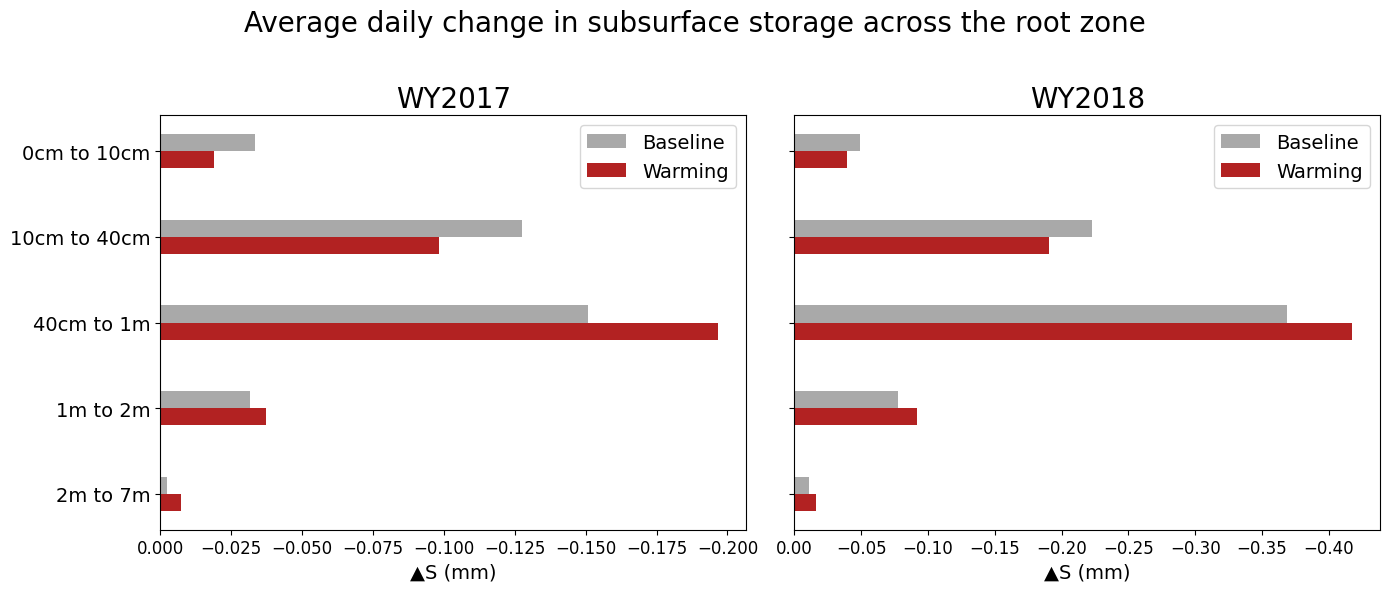

In [12]:
categories =['0cm to 10cm', '10cm to 40cm', '40cm to 1m', '1m to 2m', '2m to 7m']
y = np.arange(len(categories))
bar_height = 0.2


baseline_2017 = [subsurf_change_10cm_avg_domain,
subsurf_change_40cm_avg_domain,
subsurf_change_1m_avg_domain,
subsurf_change_2m_avg_domain,
subsurf_change_7m_avg_domain]

warm_2017 = [subsurf_change_10cm_avg_domain_warm,
subsurf_change_40cm_avg_domain_warm,
subsurf_change_1m_avg_domain_warm,
subsurf_change_2m_avg_domain_warm,
subsurf_change_7m_avg_domain_warm]


baseline_2018 = [subsurf_change_10cm_avg_domain_2018,
subsurf_change_40cm_avg_domain_2018,
subsurf_change_1m_avg_domain_2018,
subsurf_change_2m_avg_domain_2018,
subsurf_change_7m_avg_domain_2018]

warm_2018 = [subsurf_change_10cm_avg_domain_2018_warm,
subsurf_change_40cm_avg_domain_2018_warm,
subsurf_change_1m_avg_domain_2018_warm,
subsurf_change_2m_avg_domain_2018_warm,
subsurf_change_7m_avg_domain_2018_warm]

fig, axes = plt.subplots(1, 2, figsize=(14, 6))
fig.suptitle('Average daily change in subsurface storage across the root zone', fontsize=20)

axes[0].barh(y - bar_height/2, baseline_2017, height=bar_height, color='#a9a9a9', label='Baseline')
axes[0].barh(y + bar_height/2, warm_2017, height=bar_height, color='firebrick', label='Warming')
axes[0].invert_xaxis()
axes[0].invert_yaxis()
axes[0].set_yticks(y)
axes[0].set_yticklabels(categories, fontsize=14)
axes[0].set_xlabel('\u25B2S (mm)', fontsize=14)
axes[0].set_title('WY2017', fontsize=20)
axes[0].legend(fontsize=14)
axes[0].tick_params(axis='x', labelsize=12)

axes[1].barh(y - bar_height/2, baseline_2018, height=bar_height, color='#a9a9a9', label='Baseline')
axes[1].barh(y + bar_height/2, warm_2018, height=bar_height, color='firebrick', label='Warming')
axes[1].invert_xaxis()
axes[1].set_yticks(y)
axes[1].set_yticklabels([])  
axes[1].set_ylim(axes[0].get_ylim())  
axes[1].set_xlabel('\u25B2S (mm)', fontsize=14)
axes[1].set_title('WY2018', fontsize=20)
axes[1].legend(fontsize=14)
axes[1].tick_params(axis='x', labelsize=12)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

## Changes in subsurface storage over the entire summer

In [26]:
# baseline
subsurf_summerchange_10cm = np.zeros((ny,nx))
subsurf_summerchange_40cm = np.zeros((ny,nx))
subsurf_summerchange_1m = np.zeros((ny,nx))
subsurf_summerchange_2m = np.zeros((ny,nx))
subsurf_summerchange_7m = np.zeros((ny,nx))


# change in subsurface storage over the summer for each pixel
#last array element (last hour of august) - first array element (first hour of july)
subsurf_summerchange_10cm = (subsurf_storage_bylayer[-1, 9,:,:] - subsurf_storage_bylayer[0,9,:,:])*nanmask
subsurf_summerchange_40cm = (subsurf_storage_bylayer[-1, 8,:,:] - subsurf_storage_bylayer[0,8,:,:])*nanmask
subsurf_summerchange_1m = (subsurf_storage_bylayer[-1, 7,:,:] - subsurf_storage_bylayer[0,7,:,:])*nanmask
subsurf_summerchange_2m = (subsurf_storage_bylayer[-1, 6,:,:] - subsurf_storage_bylayer[0,6,:,:])*nanmask
subsurf_summerchange_7m = (subsurf_storage_bylayer[-1, 5,:,:] - subsurf_storage_bylayer[0,5,:,:])*nanmask


# domain average
subsurf_summerchange_10cm_avg_domain = np.nanmean(subsurf_summerchange_10cm*nanmask)
subsurf_summerchange_40cm_avg_domain = np.nanmean(subsurf_summerchange_40cm*nanmask)
subsurf_summerchange_1m_avg_domain = np.nanmean(subsurf_summerchange_1m*nanmask)
subsurf_summerchange_2m_avg_domain = np.nanmean(subsurf_summerchange_2m*nanmask)
subsurf_summerchange_7m_avg_domain = np.nanmean(subsurf_summerchange_7m*nanmask)


print(subsurf_summerchange_10cm_avg_domain)
print(subsurf_summerchange_40cm_avg_domain)
print(subsurf_summerchange_1m_avg_domain)
print(subsurf_summerchange_2m_avg_domain)
print(subsurf_summerchange_7m_avg_domain)


-1827.7983416345646
-8581.732531753343
-9881.322657357598
-2003.4265548972112
-143.58806813837992


In [27]:
# warming
subsurf_summerchange_10cm_warm = np.zeros((ny,nx))
subsurf_summerchange_40cm_warm = np.zeros((ny,nx))
subsurf_summerchange_1m_warm = np.zeros((ny,nx))
subsurf_summerchange_2m_warm = np.zeros((ny,nx))
subsurf_summerchange_7m_warm = np.zeros((ny,nx))


# change in subsurface storage over the summer for each pixel
subsurf_summerchange_10cm_warm = (subsurf_storage_bylayer_warm[-1, 9,:,:] - subsurf_storage_bylayer_warm[0,9,:,:])*nanmask
subsurf_summerchange_40cm_warm = (subsurf_storage_bylayer_warm[-1, 8,:,:] - subsurf_storage_bylayer_warm[0,8,:,:])*nanmask
subsurf_summerchange_1m_warm = (subsurf_storage_bylayer_warm[-1, 7,:,:] - subsurf_storage_bylayer_warm[0,7,:,:])*nanmask
subsurf_summerchange_2m_warm = (subsurf_storage_bylayer_warm[-1, 6,:,:] - subsurf_storage_bylayer_warm[0,6,:,:])*nanmask
subsurf_summerchange_7m_warm = (subsurf_storage_bylayer_warm[-1, 5,:,:] - subsurf_storage_bylayer_warm[0,5,:,:])*nanmask


# domain average
subsurf_summerchange_10cm_avg_domain_warm = np.nanmean(subsurf_summerchange_10cm_warm*nanmask)
subsurf_summerchange_40cm_avg_domain_warm = np.nanmean(subsurf_summerchange_40cm_warm*nanmask)
subsurf_summerchange_1m_avg_domain_warm = np.nanmean(subsurf_summerchange_1m_warm*nanmask)
subsurf_summerchange_2m_avg_domain_warm = np.nanmean(subsurf_summerchange_2m_warm*nanmask)
subsurf_summerchange_7m_avg_domain_warm = np.nanmean(subsurf_summerchange_7m_warm*nanmask)


print(subsurf_summerchange_10cm_avg_domain_warm)
print(subsurf_summerchange_40cm_avg_domain_warm)
print(subsurf_summerchange_1m_avg_domain_warm)
print(subsurf_summerchange_2m_avg_domain_warm)
print(subsurf_summerchange_7m_avg_domain_warm)

-894.0572718732577
-6678.711814710881
-12820.861545170563
-2379.146275653567
-456.7552971656501


In [37]:
# WY2018 values (from other notebook)

subsurf_summerchange_10cm_avg_domain_2018 = -3247.880086336795
subsurf_summerchange_40cm_avg_domain_2018 = -14348.538946783197
subsurf_summerchange_1m_avg_domain_2018 = -23225.212097436575
subsurf_summerchange_2m_avg_domain_2018 = -4874.215853849633
subsurf_summerchange_7m_avg_domain_2018 = -697.3310917001415

subsurf_summerchange_10cm_avg_domain_2018_warm = -2638.353050319306
subsurf_summerchange_40cm_avg_domain_2018_warm = -12348.92312386109
subsurf_summerchange_1m_avg_domain_2018_warm = -26236.201971891664
subsurf_summerchange_2m_avg_domain_2018_warm = -5774.803177760121
subsurf_summerchange_7m_avg_domain_2018_warm = -1016.3741123516851

In [31]:
# converting from m3 to mm - WY2017
# these values represent the per-pixel domain average, so just have to divide by pixel size (1km2 = 1e12 mm2)
# currently in m3 = 1e9 mm3

# baseline
# convert to mm3
subsurf_summerchange_10cm_avg_domain = subsurf_summerchange_10cm_avg_domain * 10**9 
subsurf_summerchange_40cm_avg_domain = subsurf_summerchange_40cm_avg_domain * 10**9
subsurf_summerchange_1m_avg_domain = subsurf_summerchange_1m_avg_domain * 10**9
subsurf_summerchange_2m_avg_domain = subsurf_summerchange_2m_avg_domain * 10**9
subsurf_summerchange_7m_avg_domain = subsurf_summerchange_7m_avg_domain * 10**9

# convert to mm
subsurf_summerchange_10cm_avg_domain = subsurf_summerchange_10cm_avg_domain / 10**12
subsurf_summerchange_40cm_avg_domain = subsurf_summerchange_40cm_avg_domain / 10**12
subsurf_summerchange_1m_avg_domain = subsurf_summerchange_1m_avg_domain / 10**12
subsurf_summerchange_2m_avg_domain = subsurf_summerchange_2m_avg_domain / 10**12
subsurf_summerchange_7m_avg_domain = subsurf_summerchange_7m_avg_domain / 10**12


# warmed
subsurf_summerchange_10cm_avg_domain_warm = subsurf_summerchange_10cm_avg_domain_warm * 10**9 
subsurf_summerchange_40cm_avg_domain_warm = subsurf_summerchange_40cm_avg_domain_warm * 10**9
subsurf_summerchange_1m_avg_domain_warm = subsurf_summerchange_1m_avg_domain_warm * 10**9
subsurf_summerchange_2m_avg_domain_warm = subsurf_summerchange_2m_avg_domain_warm * 10**9
subsurf_summerchange_7m_avg_domain_warm = subsurf_summerchange_7m_avg_domain_warm * 10**9

subsurf_summerchange_10cm_avg_domain_warm = subsurf_summerchange_10cm_avg_domain_warm / 10**12
subsurf_summerchange_40cm_avg_domain_warm = subsurf_summerchange_40cm_avg_domain_warm / 10**12
subsurf_summerchange_1m_avg_domain_warm = subsurf_summerchange_1m_avg_domain_warm / 10**12
subsurf_summerchange_2m_avg_domain_warm = subsurf_summerchange_2m_avg_domain_warm / 10**12
subsurf_summerchange_7m_avg_domain_warm = subsurf_summerchange_7m_avg_domain_warm / 10**12

In [38]:
# converting from m3 to mm - WY2018
# these values represent the per-pixel domain average, so just have to divide by pixel size (1km2 = 1e12 mm2)
# currently in m3 = 1e9 mm3

# baseline
# convert to mm3
subsurf_summerchange_10cm_avg_domain_2018 = subsurf_summerchange_10cm_avg_domain_2018 * 10**9 
subsurf_summerchange_40cm_avg_domain_2018 = subsurf_summerchange_40cm_avg_domain_2018 * 10**9
subsurf_summerchange_1m_avg_domain_2018 = subsurf_summerchange_1m_avg_domain_2018 * 10**9
subsurf_summerchange_2m_avg_domain_2018 = subsurf_summerchange_2m_avg_domain_2018 * 10**9
subsurf_summerchange_7m_avg_domain_2018 = subsurf_summerchange_7m_avg_domain_2018 * 10**9

# convert to mm
subsurf_summerchange_10cm_avg_domain_2018 = subsurf_summerchange_10cm_avg_domain_2018 / 10**12
subsurf_summerchange_40cm_avg_domain_2018 = subsurf_summerchange_40cm_avg_domain_2018 / 10**12
subsurf_summerchange_1m_avg_domain_2018 = subsurf_summerchange_1m_avg_domain_2018 / 10**12
subsurf_summerchange_2m_avg_domain_2018 = subsurf_summerchange_2m_avg_domain_2018 / 10**12
subsurf_summerchange_7m_avg_domain_2018 = subsurf_summerchange_7m_avg_domain_2018 / 10**12


# warmed
subsurf_summerchange_10cm_avg_domain_2018_warm = subsurf_summerchange_10cm_avg_domain_2018_warm * 10**9 
subsurf_summerchange_40cm_avg_domain_2018_warm = subsurf_summerchange_40cm_avg_domain_2018_warm * 10**9
subsurf_summerchange_1m_avg_domain_2018_warm = subsurf_summerchange_1m_avg_domain_2018_warm * 10**9
subsurf_summerchange_2m_avg_domain_2018_warm = subsurf_summerchange_2m_avg_domain_2018_warm * 10**9
subsurf_summerchange_7m_avg_domain_2018_warm = subsurf_summerchange_7m_avg_domain_2018_warm * 10**9

subsurf_summerchange_10cm_avg_domain_2018_warm = subsurf_summerchange_10cm_avg_domain_2018_warm / 10**12
subsurf_summerchange_40cm_avg_domain_2018_warm = subsurf_summerchange_40cm_avg_domain_2018_warm / 10**12
subsurf_summerchange_1m_avg_domain_2018_warm = subsurf_summerchange_1m_avg_domain_2018_warm / 10**12
subsurf_summerchange_2m_avg_domain_2018_warm = subsurf_summerchange_2m_avg_domain_2018_warm / 10**12
subsurf_summerchange_7m_avg_domain_2018_warm = subsurf_summerchange_7m_avg_domain_2018_warm / 10**12

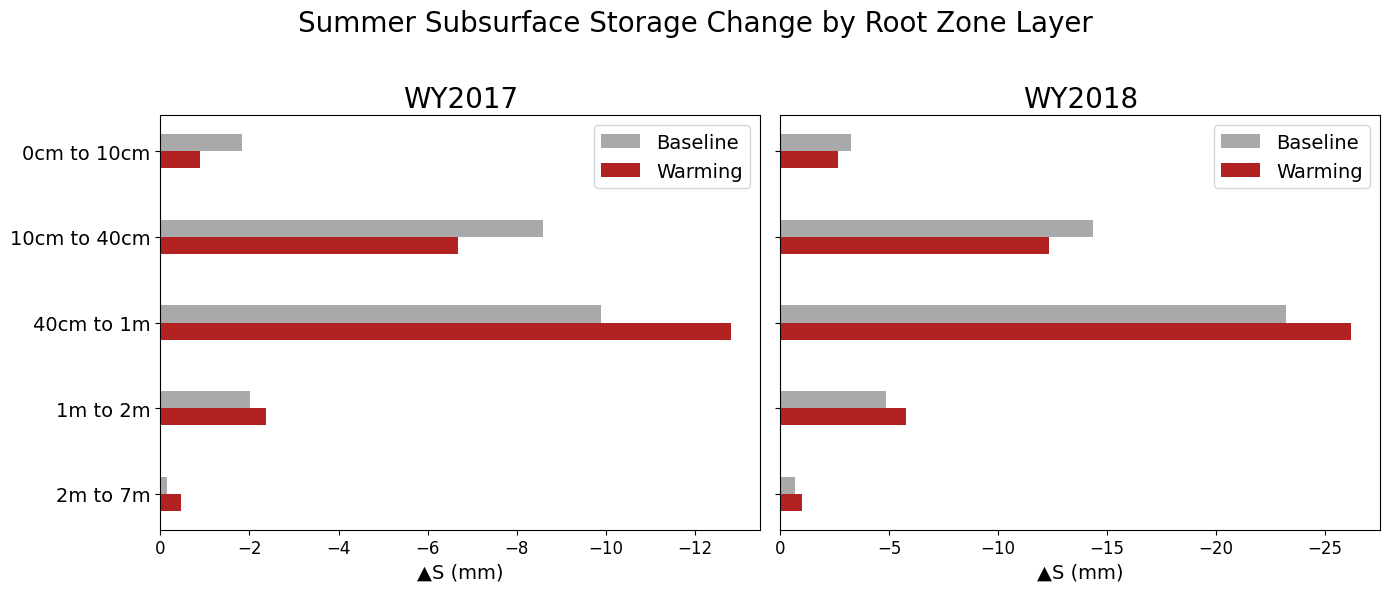

In [40]:
categories =['0cm to 10cm', '10cm to 40cm', '40cm to 1m', '1m to 2m', '2m to 7m']
y = np.arange(len(categories))
bar_height = 0.2


baseline_2017 = [subsurf_summerchange_10cm_avg_domain,
subsurf_summerchange_40cm_avg_domain,
subsurf_summerchange_1m_avg_domain,
subsurf_summerchange_2m_avg_domain,
subsurf_summerchange_7m_avg_domain]

warm_2017 = [subsurf_summerchange_10cm_avg_domain_warm,
subsurf_summerchange_40cm_avg_domain_warm,
subsurf_summerchange_1m_avg_domain_warm,
subsurf_summerchange_2m_avg_domain_warm,
subsurf_summerchange_7m_avg_domain_warm]


baseline_2018 = [subsurf_summerchange_10cm_avg_domain_2018,
subsurf_summerchange_40cm_avg_domain_2018,
subsurf_summerchange_1m_avg_domain_2018,
subsurf_summerchange_2m_avg_domain_2018,
subsurf_summerchange_7m_avg_domain_2018]

warm_2018 = [subsurf_summerchange_10cm_avg_domain_2018_warm,
subsurf_summerchange_40cm_avg_domain_2018_warm,
subsurf_summerchange_1m_avg_domain_2018_warm,
subsurf_summerchange_2m_avg_domain_2018_warm,
subsurf_summerchange_7m_avg_domain_2018_warm]

fig, axes = plt.subplots(1, 2, figsize=(14, 6))
fig.suptitle('Summer Subsurface Storage Change by Root Zone Layer', fontsize=20)

axes[0].barh(y - bar_height/2, baseline_2017, height=bar_height, color='#a9a9a9', label='Baseline')
axes[0].barh(y + bar_height/2, warm_2017, height=bar_height, color='firebrick', label='Warming')
axes[0].invert_xaxis()
axes[0].invert_yaxis()
axes[0].set_yticks(y)
axes[0].set_yticklabels(categories, fontsize=14)
axes[0].set_xlabel('\u25B2S (mm)', fontsize=14)
axes[0].set_title('WY2017', fontsize=20)
axes[0].legend(fontsize=14)
axes[0].tick_params(axis='x', labelsize=12)

axes[1].barh(y - bar_height/2, baseline_2018, height=bar_height, color='#a9a9a9', label='Baseline')
axes[1].barh(y + bar_height/2, warm_2018, height=bar_height, color='firebrick', label='Warming')
axes[1].invert_xaxis()
axes[1].set_yticks(y)
axes[1].set_yticklabels([])  
axes[1].set_ylim(axes[0].get_ylim())  
axes[1].set_xlabel('\u25B2S (mm)', fontsize=14)
axes[1].set_title('WY2018', fontsize=20)
axes[1].legend(fontsize=14)
axes[1].tick_params(axis='x', labelsize=12)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

# Summer transpiration

98.23297197821185
172.2553618541874
22.15510653248524


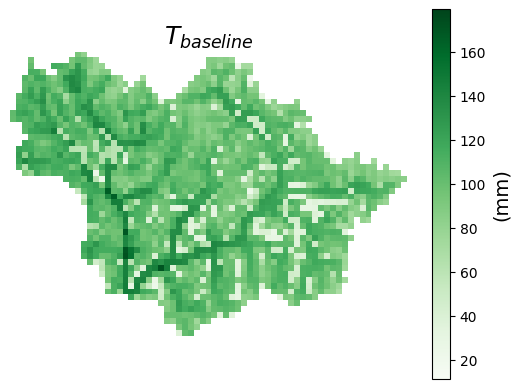

In [42]:
t_tot_summer = np.load("summer_tran_sum.npy")
plt.imshow(np.ma.masked_array(t_tot_summer, surf_mask==0),origin='lower', cmap = 'Greens', vmax = 179.49582531790148, vmin =11.315879827741224)
cbar = plt.colorbar()
plt.axis('off')
plt.title('$T_{baseline}$', fontsize = 18)
cbar.set_label('(mm)', fontsize = 14)  # Set the label for the colorbar
basin_avg_t = np.nanmean(t_tot_summer*nanmask)
print(basin_avg_t)
print(np.nanmax(t_tot_summer*nanmask))
print(np.nanmin(t_tot_summer*nanmask))

178


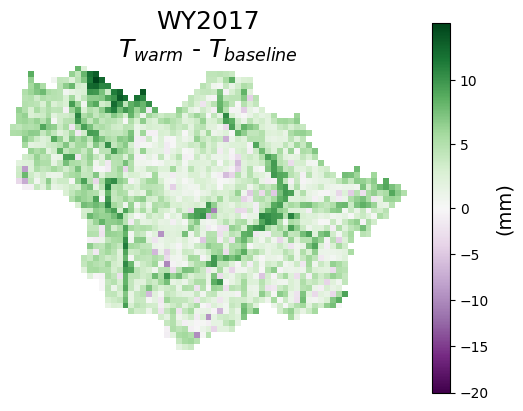

In [30]:
t_tot_summer_warm = np.load('summer_tran_sum_warm.npy')
twarm_tbaseline = t_tot_summer_warm - t_tot_summer
norm = colors.TwoSlopeNorm(vmin=-20.0514608725505, vcenter=0, vmax=14.45666876408606)
im = plt.imshow(np.ma.masked_array(twarm_tbaseline, surf_mask==0), norm = norm, origin='lower', cmap='PRGn')

cbar = plt.colorbar(im)
cbar.set_label('(mm)', fontsize = 14)  # Set the label for the colorbar

plt.axis('off')
plt.title('WY2017\n$T_{warm}$ - $T_{baseline}$', fontsize = 18)
twarm_tbaseline.max()

num_drops = 0
twarm_tbaseline = twarm_tbaseline*nanmask[0]
for x in range (nx):
    for y in range (ny):
        if twarm_tbaseline[y,x] < 0:
            num_drops = num_drops+1

print(num_drops)

In [31]:
twarm_tbaseline = twarm_tbaseline*nanmask[0]
tran_inc = 0
for y in range(ny):
    for x in range(nx):
        if twarm_tbaseline[y,x] > 0:
            tran_inc+=1

tran_perc_inc = tran_inc/1883
print(tran_perc_inc)

0.9054699946893255


# Summer recharge

In [4]:
# finding area of basin with positive I-T (recharge area)
# each pixel is 1km, so can just sum pixels
summer_infl_sum = np.load("summer_infl_sum.npy")

diff_infil_T = (summer_infl_sum - summer_tran_sum)*nanmask[0]


recharge_area = 0
for y in range (0, ny):
    for x in range (0,nx):
        if diff_infil_T[y,x] >= 0:
            recharge_area +=1

print(recharge_area)


504


In [5]:
print(np.nanmin(diff_infil_T))
print(np.nanmax(diff_infil_T))

-112.00099373119227
111.55531418416751


(48, 67)

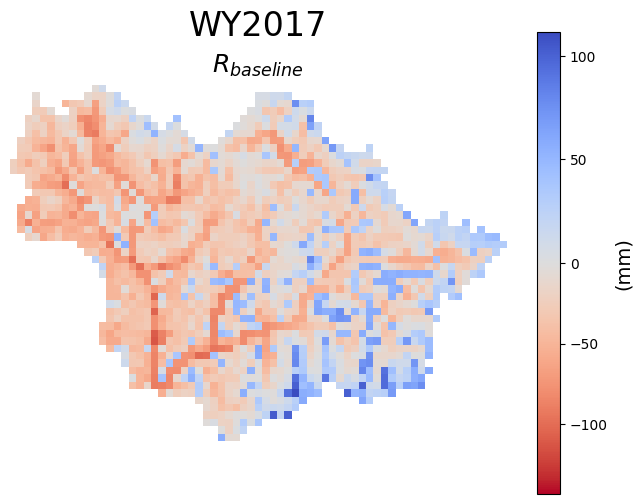

In [7]:
# how much water that infiltrates is transpired?
fig, ax = plt.subplots(1, 1, figsize=(8, 6))

norm = colors.TwoSlopeNorm(vmin=-143.35924588339816, vcenter=0, vmax=np.nanmax(diff_infil_T)) 

im = ax.imshow(np.ma.masked_array(diff_infil_T, surf_mask==0),origin='lower', norm = norm,cmap = 'coolwarm_r')
ax.axis('off')
#fig.colorbar(ax.imshow(np.ma.masked_array(diff_infil_T, surf_mask==0),origin='lower', norm = norm, cmap = 'coolwarm_r'), ax=ax)
# ax.set_title('WY2017\n$R_{baseline}$', fontsize = 20, y = 1.1)

ax.text(0.5, 1.12, 'WY2017',
        transform=ax.transAxes,
        ha='center', va='bottom',
        fontsize=24)
ax.text(0.5, 1.02, r'$R_{baseline}$',
        transform=ax.transAxes,
        ha='center', va='bottom',
        fontsize=18)
# ax.text(4,-3.5, f"Positive Recharge Area = {recharge_area} $km^2$", fontsize = 18)
cbar = fig.colorbar(im, ax=ax)
cbar.set_label('(mm)', fontsize=14)
diff_infil_T.shape


In [10]:
diff_infil_T_warm = np.load('diff_infil_T_warm.npy')

-3.4630752326763075
-20.559710663968104
-17.0966354312918


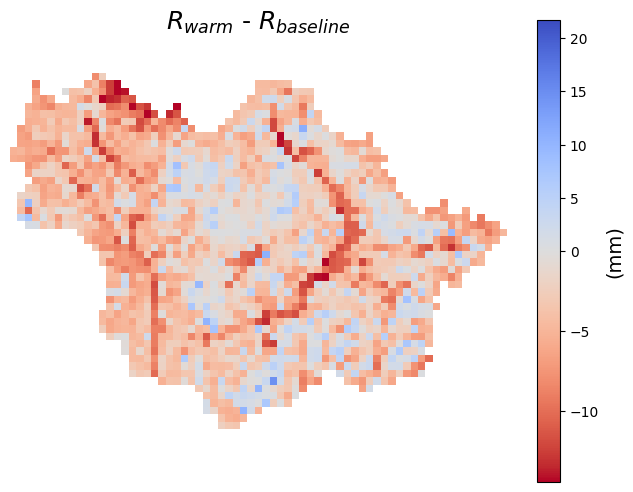

In [15]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
recharge_diff = diff_infil_T_warm- diff_infil_T
#vmin=-14.42 min from warm run
norm = colors.TwoSlopeNorm(vmin=-14.424376945466804, vcenter=0, vmax=21.710990816161797) # max and min from WY2018

im = ax.imshow(np.ma.masked_array(recharge_diff, surf_mask == 0),
               origin='lower', norm=norm, cmap='coolwarm_r')

cbar = fig.colorbar(im, ax=ax)
cbar.set_label('(mm)', fontsize=14)

ax.axis('off')
ax.set_title('$R_{warm}$ - $R_{baseline}$', fontsize=18, y=1.1)

print(np.nanmean(recharge_diff))
print(np.nanmean(diff_infil_T_warm))
print(np.nanmean(diff_infil_T))


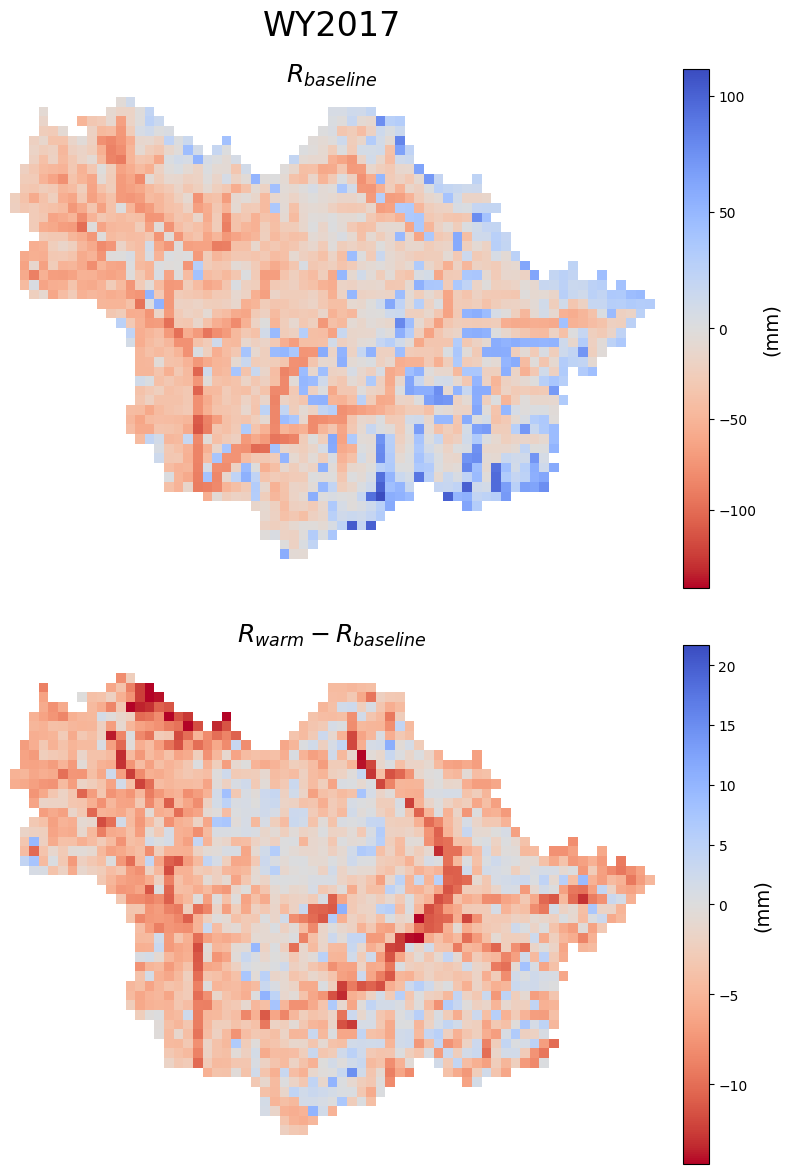

In [27]:
fig, axes = plt.subplots(2, 1, figsize=(8, 12))

ax = axes[0]

norm1 = colors.TwoSlopeNorm(vmin=-143.35924588339816,vcenter=0,vmax=np.nanmax(diff_infil_T))

im1 = ax.imshow(np.ma.masked_array(diff_infil_T, surf_mask == 0), origin='lower', norm=norm1, cmap='coolwarm_r')

ax.axis('off')

ax.text(0.5, 1.12, 'WY2017', transform=ax.transAxes, ha='center', va='bottom', fontsize=24)

ax.text(0.5, 1.02, r'$R_{baseline}$', transform=ax.transAxes, ha='center', va='bottom', fontsize=18)

cbar1 = fig.colorbar(im1, ax=ax, fraction=0.046, pad=0.04)
cbar1.set_label('(mm)', fontsize=14)


ax = axes[1]

recharge_diff = diff_infil_T_warm - diff_infil_T

norm2 = colors.TwoSlopeNorm(vmin=-14.424376945466804, vcenter=0, vmax=21.710990816161797)
im2 = ax.imshow(np.ma.masked_array(recharge_diff, surf_mask == 0), origin='lower', norm=norm2, cmap='coolwarm_r')

ax.axis('off')
ax.set_title(r'$R_{warm} - R_{baseline}$', fontsize=18, y=1.05)

cbar2 = fig.colorbar(im2, ax=ax, fraction=0.046, pad=0.04)
cbar2.set_label('(mm)', fontsize=14)

plt.tight_layout()
plt.show()


## Landcover info

In [16]:
import csv

# modified code from chatGPT
# function to convert a dat file to a csv
def convert_dat_to_csv(dat_filepath, csv_filepath, delimiter=','):
    """
    Converts a .dat file to a .csv file.

    Args:
        dat_filepath (str): Path to the .dat file.
        csv_filepath (str): Path to the output .csv file.
        delimiter (str, optional): Delimiter used in the .dat file. Defaults to ','.
    """
    try:
        with open(dat_filepath, 'r') as dat_file, open(csv_filepath, 'w', newline='') as csv_file:
            csv_writer = csv.writer(csv_file, delimiter=delimiter)
            
            for line in dat_file:
                # Split on any whitespace (space, tab, etc.)
                data = line.strip().split()
                
                # Write the row of data to the csv file
                csv_writer.writerow(data)
                

dat_file_path = '~/EastTaylor_inputs/newbounds_WY2017/drv_vegm.dat'
csv_file_path = '~/EastTaylor_inputs/newbounds_WY2017/drv_vegm.csv'
convert_dat_to_csv(dat_file_path, csv_file_path)

In [17]:
new_header = ['x', 'y', 'lat', 'lon', 'sand', 'clay', 'color', 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18]  

vegm = pd.read_csv('~/EastTaylor_inputs/newbounds_WY2017/drv_vegm.csv', delimiter=',', skiprows = 2, names = new_header)

vegm

,x,y,lat,lon,sand,clay,color,1,2,3,...,9,10,11,12,13,14,15,16,17,18
0,1,1,38.584524,-107.062561,0.43,0.19,5,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2,1,38.585682,-107.050826,0.59,0.16,5,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,3,1,38.586839,-107.039091,0.45,0.20,5,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,1,38.587995,-107.027355,0.41,0.19,5,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,1,38.589149,-107.015619,0.47,0.19,2,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3211,63,48,39.085625,-106.399371,0.66,0.11,5,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3212,64,48,39.086708,-106.387529,0.67,0.11,5,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3213,65,48,39.087790,-106.375687,0.67,0.11,5,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3214,66,48,39.088870,-106.363845,0.67,0.11,5,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [18]:
vegm = vegm.drop(['lat', 'lon', 'sand', 'clay', 'color'], axis = 1)
vegm.head()

,x,y,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,3,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,4,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,5,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0


In [19]:
# Assuming 'df' is your DataFrame with 'x', 'y' coordinates and landcover columns
landcover_columns = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18] # List of your landcover columns
x_col = 'x'
y_col = 'y'

# Identify the landcover type at each (x, y) coordinate by finding the column with the value 1
vegm['landcover_type'] = vegm[landcover_columns].idxmax(axis=1)

# Create a pivot table (reshaping data to grid-like format)
landcover_map = vegm.pivot(index=y_col, columns=x_col, values='landcover_type')

# Now landcover_map will have x_coordinates as columns and y_coordinates as rows
landcover_map = landcover_map.astype(int) 
landcover_map.shape



(48, 67)

nan


Text(0.5, 1.0, 'Landcover from vegm')

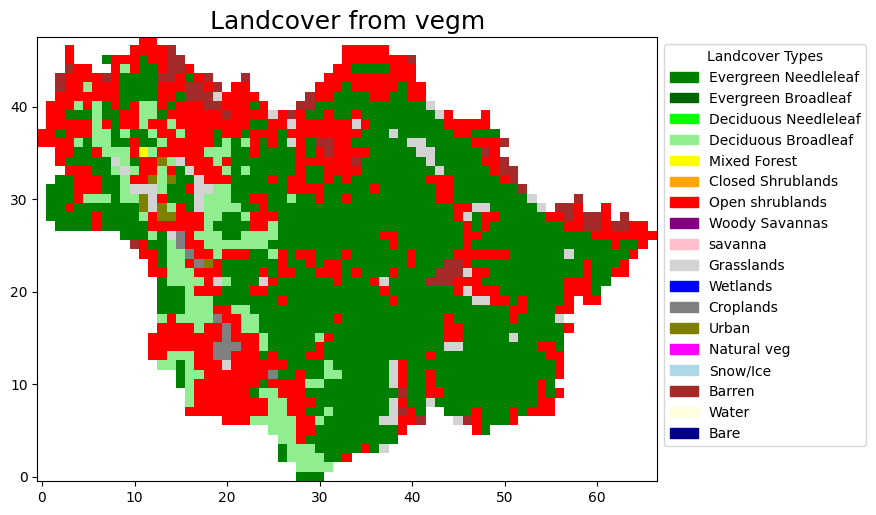

In [21]:
import matplotlib.patches as mpatches
nanmask=mask.copy()
nanmask[nanmask == 0] = 'NaN'
nanmask[nanmask > 0] = 1

landcover_names = {
    1: 'Evergreen Needleleaf', 2: 'Evergreen Broadleaf', 3: 'Deciduous Needleleaf', 4: 'Deciduous Broadleaf', 5: 'Mixed Forest', 
    6: 'Closed Shrublands', 7: 'Open shrublands', 8: 'Woody Savannas', 9: 'savanna', 10: 'Grasslands', 
    11: 'Wetlands', 12: 'Croplands', 13: 'Urban', 14: 'Natural veg', 15: 'Snow/Ice', 
    16: 'Barren', 17: 'Water', 18: 'Bare'
}

landcover_colors = {
    1: 'green', 2: 'darkgreen', 3: 'lime', 4: 'lightgreen', 5: 'yellow', 
    6: 'orange', 7: 'red', 8: 'purple', 9: 'pink', 10: 'lightgray', 
    11: 'blue', 12: 'gray', 13: 'olive', 14: 'magenta', 15: 'lightblue', 
    16: 'brown', 17: 'lightyellow', 18: 'darkblue'
}

landcover_map = landcover_map.astype(int) 

#masking the landcover map so that values outside domain are nan
landcover_map_masked = landcover_map*nanmask[0]
landcover_map_masked.head()
print(landcover_map_masked.loc[1,1])

plt.figure(figsize=(8, 6))

cmap = plt.cm.colors.ListedColormap(list(landcover_colors.values()))
bounds = np.arange(0, 19, 1)  # Bounds for the 18 landcover types (1-18)
norm = plt.Normalize(vmin=1, vmax=18)

plt.imshow(np.ma.masked_array(landcover_map_masked.values, mask[-1,:,:]==0), interpolation='nearest', cmap=cmap, norm=norm, origin = 'lower')

handles = [mpatches.Patch(color=color, label=landcover_names[landcover_type]) 
           for landcover_type, color in landcover_colors.items()]
plt.legend(handles=handles, title="Landcover Types", loc='upper left', bbox_to_anchor=(1, 1))
#plt.axis('off')
plt.title("Landcover from vegm", fontsize = 18)